# Apply a spectral sea level equation solver to  Antarctic drainage basin outlines
*Author: R. Rietbroek Jan 2025 (r.rietbroek@utwente.nl)*

When a surface load, e.g. a changing glacier load, is applied on the crust of the Earth it induces changes in gravity and a deformation of teh Earth. A passive but self-consistent ocean responds by adapting to the new geoid but also enforces a mass conservation (e.g. the mass from the melting glacier should be added to the ocean). This are generally considered Self Attraction and Loading (SAL) effects. The theory goes back to Woodward 1888 ("On the form and position of mean sea level"). A spectral approach, specialized for ocean pole tide is provided in Dahlen 1976 ("The passive influence of the oceans upon the rotation of the Earth").

For a given surface load, the computation of a SAL response of the ocean can be done by solving the sea level equation. This notebook demonstrates the use of the specral sea level solves as provided by shxarray.

## 1. Preparations

In [1]:
#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2

In [2]:
from shxarray.earth.sealevel import SpectralSeaLevelSolver
import xarray as xr
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from shxarray.core.logging import setWarningLevel

setWarningLevel()

In [3]:
#set the maximum degree of the sea level equation solver
nmax=120

## 2. Get a set of Antartic grounded drainage basins to use as continental loads
We're reusing the results from [this shxarray notebook](https://github.com/ITC-Water-Resources/shxarray/blob/main/docs/source/notebooks/Geometry2sphericalHarmonics.ipynb).

In [4]:
furl="https://github.com/strawpants/geoshapes/raw/refs/heads/master/cryo/antarc_ddiv_icesat_grnd_n120.nc"
if not os.path.exists("data"):
    os.makedirs("data")
fout=os.path.join("data",os.path.basename(furl))

if not os.path.exists(fout):
    r=requests.get(furl)
    print("Downloading Spherical harmonic expansion of drainage basins")
    with open(fout,'wb') as fid:
        fid.write(r.content)

dantsh=xr.open_dataset(fout).sh.build_nmindex().ant_div
display(dantsh)

/usr/lib/python3.13/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'sinex' loading failed:
module 'shxarray.io.shiobackend' has no attribute 'SINEXBackEntryPoint'
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


<xarray.DataArray 'ant_div' (basinid: 27, nm: 14641)> Size: 3MB
[395307 values with dtype=float64]
Coordinates:
  * basinid  (basinid) float64 216B 2.0 3.0 4.0 5.0 6.0 ... 25.0 26.0 27.0 27.0
  * nm       (nm) object 117kB MultiIndex
  * n        (nm) int64 117kB 0 1 1 1 2 2 2 2 ... 120 120 120 120 120 120 120
  * m        (nm) int64 117kB 0 -1 0 1 -2 -1 0 1 ... 114 115 116 117 118 119 120
Attributes:
    Conventions:  CF-1.8
    source:       shxarray-1.3.3.dev5+ga1b06ac.d20250527 <https://github.com/...
    contact:      Roelof Rietbroek <r.rietbroek@utwente.nl>
    institution:  ITC Faculty of Geo-Information Science and Earth Observatio...
    comments:     Used backend: SHTns High performance Spherical Harmonic Tra...
    history:      Analysis operation

## 3 Set up the sea level solver
This class precomputes and caches a product2sum matrix of the ocean function which can take a while for higher degrees. It is also possible to add a custom ocean function expressed in spherical harmonic coefficients. The default uses the ocean sh coefficients from [this notebook](https://github.com/ITC-Water-Resources/shxarray/blob/main/docs/source/notebooks/OceanMask.ipynb)

In [5]:
rotfeedback=False #possibly set to True to also apply rotational feedback
sle=SpectralSeaLevelSolver(nmax=nmax,rotfeedback=rotfeedback)

shxarray-WARNING: Thin shell approximation is used (surface load assumed)
shxarray-WARNING: Thin shell approximation is used (surface load assumed)


In [6]:
dsant_sle=sle(dantsh)
display(dsant_sle)


<xarray.Dataset> Size: 16MB
Dimensions:     (nm: 14641, basinid: 27)
Coordinates:
  * nm          (nm) object 117kB MultiIndex
  * n           (nm) int64 117kB 0 1 1 1 2 2 2 2 ... 120 120 120 120 120 120 120
  * m           (nm) int64 117kB 0 -1 0 1 -2 -1 0 ... 115 116 117 118 119 120
  * basinid     (basinid) float64 216B 2.0 3.0 4.0 5.0 ... 25.0 26.0 27.0 27.0
Data variables:
    quasi_sea   (nm, basinid) float64 3MB -0.001249 -0.001998 ... 7.79e-11
    load_sea    (nm, basinid) float64 3MB -0.0009403 -0.001546 ... 8.519e-09
    load_force  (basinid, nm) float64 3MB ...
    geoid       (nm, basinid) float64 3MB 0.0 0.0 0.0 ... 1.938e-11 1.896e-11
    uplift      (nm, basinid) float64 3MB 0.0 0.0 0.0 ... -6.023e-11 -5.893e-11
Attributes:
    history:  2025-07-08 11:43:10.115941: shxarray (SpectralSeaLevelSolver

In [8]:
def plot_sle(dsslice):
    # dsgrid=dsslice.sh.synthesis(lon=np.arange(-180+dres/2,180,dres),lat=np.arange(-90+dres/2,-60,dres))
    dsgrid=dsslice.sh.synthesis()
    dsgrid.load_force.attrs["units"]="m"
    dsgrid.load_sea.attrs["units"]="m"
    dsgrid.quasi_sea.attrs["units"]="m"
    dsgrid.geoid.attrs["units"]="m"
    dsgrid.uplift.attrs["units"]="m"
    cmap="RdBu_r"
    cbaropts=dict(location="bottom")
    
    proj=ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-50, satellite_height=35785831) 
    fig, axs = plt.subplots(nrows=2,ncols=3, subplot_kw={'projection': proj},figsize=(12,8.5))
    ax=axs[0,0]
    dsgrid.load_force.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Drainage basin load")


    ax=axs[0,1]
    slmin=1.1*dsgrid.load_sea.min().item()
    slmax=1.1*dsgrid.load_sea.max().item()
    dsgrid.load_sea.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),vmin=slmin,vmax=slmax,cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Relative sea level")

    ax=axs[0,2]
    dsgrid.quasi_sea.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),vmin=slmin,vmax=slmax,cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Quasi Sea level")

    ax=axs[1,0]
    dsgrid.geoid.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Geoid change")

    ax=axs[1,1]
    dsgrid.uplift.plot.contourf(ax=ax,cmap=cmap,transform=ccrs.PlateCarree(),cbar_kwargs=cbaropts)
    ax.coastlines()
    ax.set_title("Uplift change")
    # plt.subplots_adjust(bottom=0.1, right=0.2, top=0.9)
    fig.delaxes(axs[1,2])
   


## 4 plot the sealevel equation components of all the drainage basin loads combined (a uniform Antarctic load)

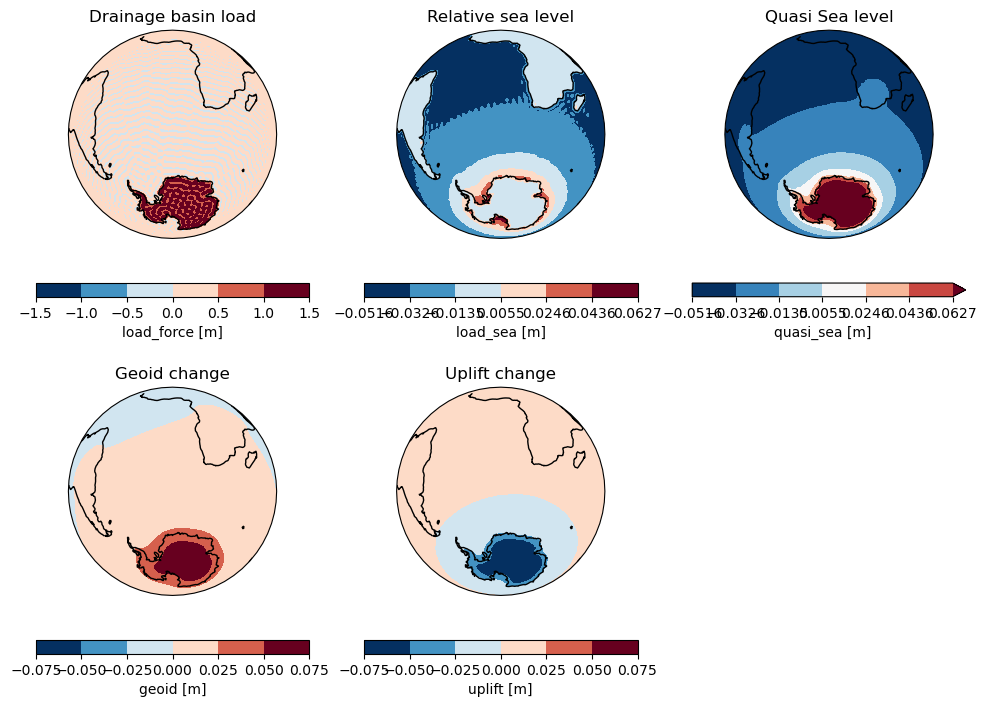

In [9]:
# plot the effects of all loads together
plot_sle(dsant_sle.sum("basinid"))


## 5 Plot the contribution for a specific basin
* Note that the truncation degree relative to the size of the load is smaller, which can be seen in ringing effects.
* Also note that the quasi Sea level is much smoother than the relative sea level close to the coastlines, but it's value over land is invalid.

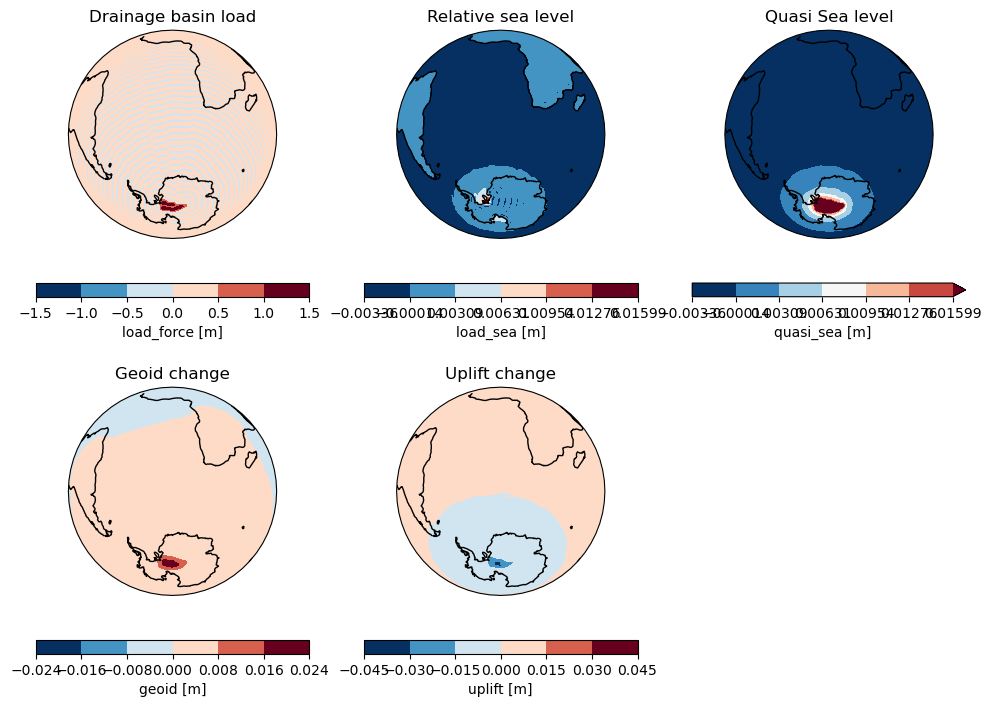

In [10]:
# plot the effect of a specific drainage basin
plot_sle(dsant_sle.sel(basinid=3))